Import libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from sklearn.svm import SVC
import pickle

## First lets read in the data and so some preprocessing to make sure the data is read in clean and correct.

In [2]:
# Read in the data from the machinelearning and datascience
df = pd.read_csv('./data/clean.csv')

# If there are NA's in clean_title. Remove them
if df.clean_title.isna().sum() > 0:
    df.drop(labels = df[df.clean_title.isna()].index, inplace = True)
    
# Clean merged column and fillna with empty string
if df.merged.isna().sum() > 0:
    df['merged'].fillna(value="",inplace=True)
    
if df.selftext.isna().sum() > 0:
    df['selftext'].fillna(value="",inplace=True)
    
if df.clean_selftext.isna().sum() > 0:
    df['clean_selftext'].fillna(value="",inplace=True)
    
if df.selftext_urls.isna().sum() > 0:
    df['selftext_urls'].fillna(value="",inplace=True)
    
if df.title_urls.isna().sum() > 0:
    df['title_urls'].fillna(value="",inplace=True)
df.head()

,title,selftext,clean_title,selftext_urls,title_urls,clean_selftext,created_utc,num_comments,num_crossposts,score,subreddit,Subreddit_name,merged
0,[D] Hinton responds to Schmidhuber,,hinton responds schmidhuber,,,,1587609168,0,0,1,MachineLearning,0,hinton responds schmidhuber
1,Hinton responds to Schmidhuber,,hinton responds schmidhuber,,,,1587609111,1,0,1,MachineLearning,0,hinton responds schmidhuber
2,"[D] Other than vectorization, what other aspec...",I'm helping a friend design a course with dual...,vectorization aspects code optimization teach ...,,,helping friend design course dual intent entry...,1587606108,2,0,1,MachineLearning,0,vectorization aspects code optimization teach ...
3,Survey for IT Employees working from home! Hel...,,survey employees working home help us finding ...,,,,1587604741,2,0,1,MachineLearning,0,survey employees working home help us finding ...
4,[R] Chip Placement with Deep Reinforcement Lea...,,r chip placement deep reinforcement learning,,,,1587604558,1,0,1,MachineLearning,0,r chip placement deep reinforcement learning


#### Begin the modeling process

- Here lets create our X and y variables
- Fit our transformers and create our subsequent models. 

In [3]:
# Create X variable

X = df[['clean_selftext', 'selftext_urls', 'title_urls', 'merged']]
y = df['Subreddit_name']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y)

To create a custom stopwords list, lets export sklearn's english stopwords, and add in our own list of stop words. 

In [4]:
# ### EDA - sklearn's stopwords, extracted
sklearn_stopwords = list(CountVectorizer(stop_words = 'english').get_stop_words())

#Custom created list
custom_stopwords = ['good','time','python','tool','source','best',
                    'learn','science','machine','deep'
                    'data','learning','science', 'scientist', 'ds'] # most common words

# Personalized stopwords
personal_stopwords = sklearn_stopwords + custom_stopwords

In [5]:
# Create functions to just return the columns that you care about
merged_data = FunctionTransformer(lambda x: x['clean_selftext'], validate=False)
selftext_url_data = FunctionTransformer(lambda x: x['selftext_urls'], validate=False)
title_url_data = FunctionTransformer(lambda x: x['title_urls'], validate=False)

## Pipeline for coef extraction

In [6]:
%%time
pipe_v3 = Pipeline([
    ('features',FeatureUnion([
        ('merged_features', Pipeline([
             ('selector', merged_data),
             ('tvec',TfidfVectorizer(max_features = 173,
                                    stop_words = personal_stopwords, 
                                    min_df = 5,
                                    max_df = .6))
         ])),
        ('selftext_url_features', Pipeline([
            ('selector',selftext_url_data),
            ('tvec',TfidfVectorizer(max_features = 12,
                                    stop_words = personal_stopwords,
                                    min_df = 5,
                                    max_df = .7))
        ])), 
        ('title_url_features', Pipeline([
            ('selector',title_url_data),
            ('tvec',TfidfVectorizer(max_features = 12,
                                    stop_words = personal_stopwords,
                                    min_df = 5,
                                    max_df = .7))
        ]))
        
    ])), 
    ('logreg', LogisticRegression())
])

params = {}

pipe_v3.fit(X_train, y_train)
print(pipe_v3.score(X_train, y_train))
print(pipe_v3.score(X_test, y_test))

cross_val_score(pipe_v3, X_train, y_train)

0.7337198780038208
0.7291373416448824
CPU times: user 16.2 s, sys: 495 ms, total: 16.7 s
Wall time: 17.7 s


array([0.73039544, 0.72419571, 0.72448467, 0.73470756, 0.72699849])

Here we actually returned a fairly consistent score. 
Train: 0.7320441063109562
Test: 0.7389905489644079

## Create an input dataframe to run some predictions.

In [7]:
X_input = pd.DataFrame({'Instructor':['Tim Book - Lecture 6.06', 
                                      'Rilley Dallas - Lecture 4.02', 
                                      'Rilley Dallas - Lecture 6.03', 
                                      'Matt Breams - Lab 5.02', 
                                      'Riley Breams - Lecture 6.03', 
                                      "Dan Ovadia - Brand Statement"],
    'clean_selftext':["Describe generalized linear models. Fit Poisson and Gamma regression models in statsmodels. Interpret coefficients from Poisson and Gamma regression models. Describe iteratively reweighted least squares.",
                      "Understand the intuition behind the KNN algorithm Describe the Bias / Variance tradeoff using hyper-parameters of KNN Implement KNN with sklearn", 
                      "Define ensemble model and describe three rationales for using ensemble models. Execute bootstrapping. Describe the differences among and implement bagged decision trees, random forests, and ExtraTrees. Identify advantages and disadvantages of using CART models.", 
                      "After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is incredibly valuable.", 
                      "Adding one more step of randomization (and thus de-correlation) yields extremely randomized trees, or ExtraTrees. These are trained using bagging (sampling of observations) and the random subspace method (sampling of features), but an additional layer of randomness is introduced.",
                      "Data engineer with a passion for putting data in context and building robust data workflows for meaningful interpretation. I am fascinated by the insurance industry's methods of carving out and assessing risk, and excited by the data science community's ability to manage and analyze data to provide insights in responding to and mitigating risk."], 
                       'selftext_urls':['', '', '','', '',''], 
                       'title_urls':['', '', '','', '','']})

Generate some predictions

In [8]:
predict = pd.DataFrame({'instructor':X_input['Instructor'], "preds":pipe_v3.predict(X_input)})
predict

,instructor,preds
0,Tim Book - Lecture 6.06,1
1,Rilley Dallas - Lecture 4.02,0
2,Rilley Dallas - Lecture 6.03,0
3,Matt Breams - Lab 5.02,1
4,Riley Breams - Lecture 6.03,0
5,Dan Ovadia - Brand Statement,1


We can now reflect on the probabilities for these predictions

In [9]:
pipe_v3.predict_proba(X_input)

array([[0.39465957, 0.60534043],
       [0.65418365, 0.34581635],
       [0.73071228, 0.26928772],
       [0.1610893 , 0.8389107 ],
       [0.59470367, 0.40529633],
       [0.01843634, 0.98156366]])

### Extract Coefficients and Features

In [10]:
pipe_coefficients = pipe_v3.named_steps['logreg'].coef_[0]

In [11]:
# Extract the features from the FeatureUnion -> Transformerlist -> tvec
merged_features = pipe_v3.named_steps['features'].transformer_list[0][1].named_steps['tvec'].get_feature_names()
st_urls_features = pipe_v3.named_steps['features'].transformer_list[1][1].named_steps['tvec'].get_feature_names()
t_urls_features = pipe_v3.named_steps['features'].transformer_list[2][1].named_steps['tvec'].get_feature_names()

In [12]:
combined_features = merged_features + st_urls_features + t_urls_features

In [13]:
len(combined_features)

190

So we have 190 total features from our vectorizers.

In [14]:
# coefficient df
coef_df = pd.DataFrame({'features':combined_features, 
                        'coef':pipe_coefficients,
                        'exp_coef':np.exp(pipe_coefficients)})
coef_df = coef_df.set_index('features')

In [15]:
coef_df.sort_values(by= 'coef', inplace = True, ascending = False)

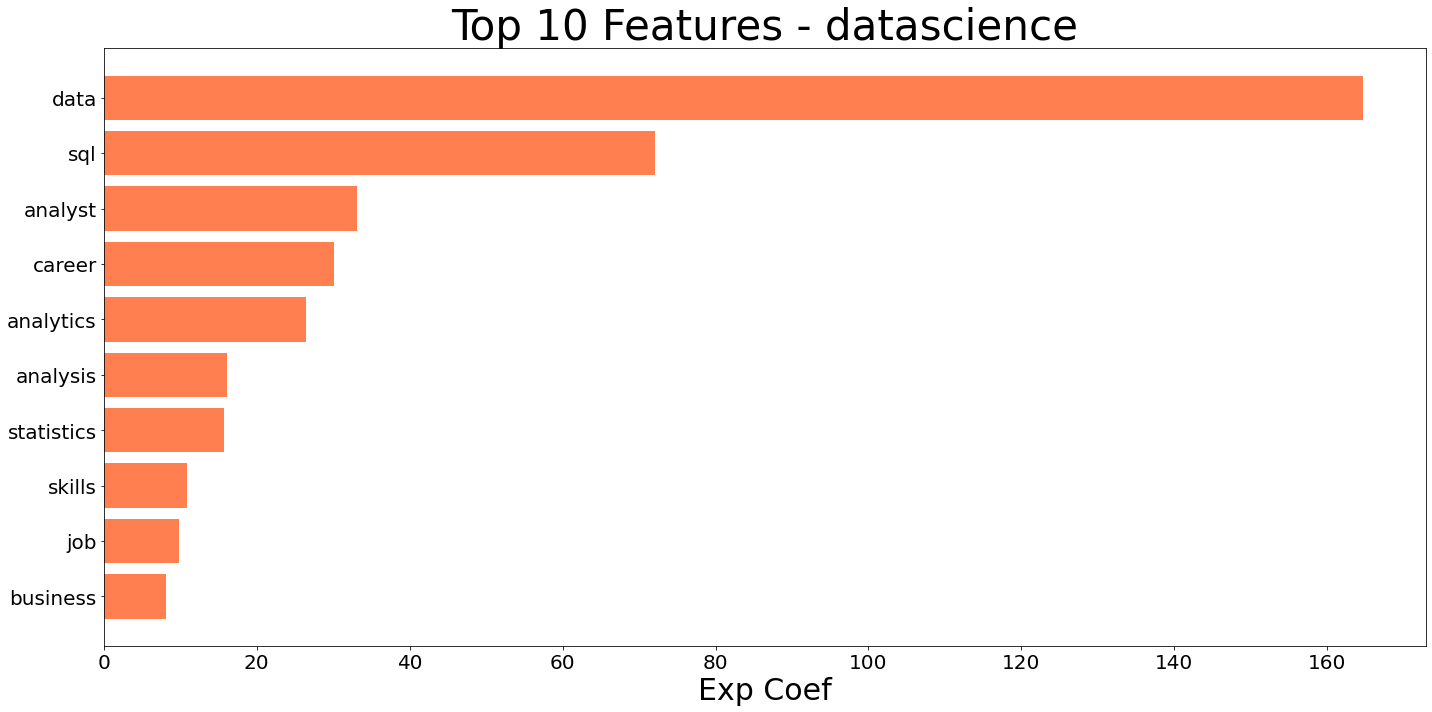

In [16]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'coral')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - datascience', fontsize=42)
plt.tight_layout()

plt.savefig('./plots/coef_datascience.png')

Here we see Data, SQL, analyst, and business oriented words having high coeffiecients. These represent, for an incremental increase in the number of times data appears in a post, the odds of it being from the datascience subreddit increases by over 160, all other variables held equal. 

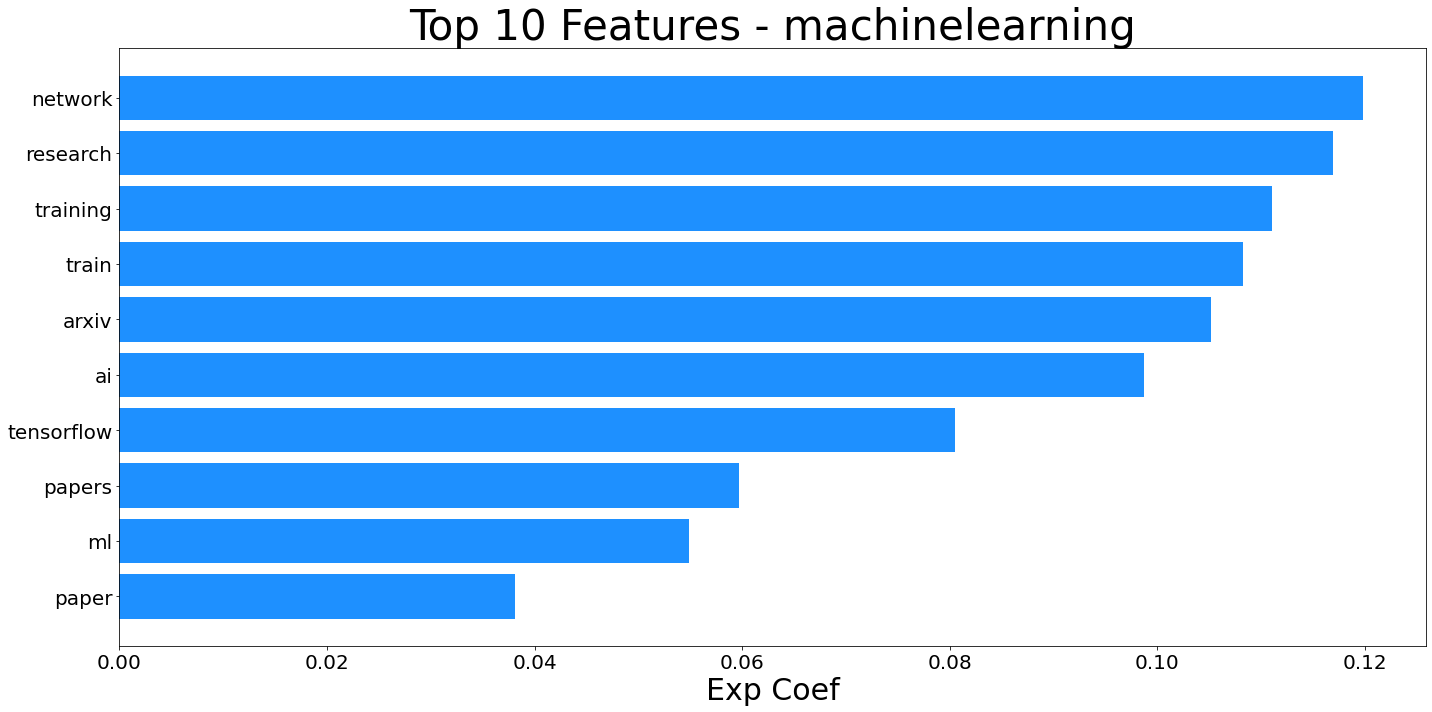

In [17]:
weights = coef_df['exp_coef'].sort_values(ascending = True).head(10)
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'dodgerblue')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - machinelearning', fontsize=42)
plt.tight_layout()

plt.savefig('./plots/coef_machinelearning.png')

In [18]:
coef_df[:20]

,coef,exp_coef
features,,
data,5.103762,164.640181
sql,4.277400,72.052865
analyst,3.500104,33.118887
career,3.404063,30.086081
analytics,3.276683,26.487756
analysis,2.777070,16.071856
statistics,2.752263,15.678065
skills,2.381852,10.824932
job,2.285763,9.833187


In [19]:
coef_df[-20:]

,coef,exp_coef
features,,
output,-1.109745,0.329643
youtube,-1.142243,0.319102
results,-1.208003,0.298794
networks,-1.264801,0.282295
input,-1.455108,0.233375
neural,-1.685598,0.185334
images,-1.888206,0.151343
arxiv,-1.914095,0.147475
deep,-1.915004,0.147341


### Instantiate TFIDF and create transformation

In [20]:
cvec = CountVectorizer(stop_words = personal_stopwords, 
                       max_features = 173, 
                       max_df = 0.8, 
                       min_df = 4)

cvec.fit(X_train['merged'], y_train)
cvec_feature_names = cvec.get_feature_names()

C_train = cvec.transform(X_train['merged'])
C_test = cvec.transform(X_test['merged'])

cvec_transformed_train_df = pd.DataFrame(C_train.toarray(),
                                        columns = cvec_feature_names)

cvec_transformed_test_df = pd.DataFrame(C_test.toarray(),
                                        columns = cvec_feature_names)

# Instantiate TFIDF
tvec = TfidfVectorizer(stop_words = personal_stopwords, 
                      max_features = 173,
                      max_df = 0.8
                     )
tvec.fit(X_train['clean_selftext'],y_train)
# Extract features names for future use
feature_names = tvec.get_feature_names()

# Transform our data: Train/Test
V_train = tvec.transform(X_train['clean_selftext'])
V_test = tvec.transform(X_test['clean_selftext'])


# convert sparse matrix to dataframe
transformed_train_df = pd.DataFrame(V_train.toarray(), 
                             columns = feature_names)

# convert sparse matrix to dataframe
transformed_test_df = pd.DataFrame(V_test.toarray(), 
                             columns = feature_names)

In [21]:
print(transformed_train_df.shape)
print(transformed_test_df.shape)

(29837, 173)
(9946, 173)


### Logistic Regression with TFIDF Vectorizer

In [22]:
%%time
# Instantiate Logistic Regression
lr = LogisticRegression(penalty = 'l2', 
                        C = 0.8,
                        random_state = 42)
# Fit
lr.fit(transformed_train_df, y_train)

# Export coeficients to series
lr_coef = pd.Series(np.exp(lr.coef_[0]), index = feature_names)

# Print Train Scores
print(cross_val_score(lr, transformed_train_df, y_train))
print(f"Train Accuracy Score: {lr.score(transformed_train_df, y_train)}")
print()

# Print Train Scores
print(cross_val_score(lr, transformed_test_df, y_test))
print(f"Test Accuracy Score: {lr.score(transformed_test_df, y_test)}")

[0.72989276 0.72939008 0.7224736  0.73386962 0.72817161]
Train Accuracy Score: 0.7328484767235312

[0.72713568 0.72900955 0.72448467 0.72599296 0.72599296]
Test Accuracy Score: 0.7287351699175548
CPU times: user 8.65 s, sys: 476 ms, total: 9.13 s
Wall time: 6.83 s


For this Logistic regression, we seem to be getting pretty consistent scores. Relatively high, but we also haven't tuned many of the parameters. Here we used a CountVectorizer.

Train score of 0.7314743439353822
Test score of 0.7382867484415846

### Apply StandardScaler
We will apply StandardScaler to our vectorized train and test data to input into SVC

In [23]:
# Instantiate StandardScaler
ss = StandardScaler()

# fit the transformation to train
ss.fit(transformed_train_df, y_train)

# transform train/test
SS_train = ss.transform(transformed_train_df)
SS_test = ss.transform(transformed_test_df)

### Logistic Regression with StandardScaler

In [24]:
# reapplying a Logistic Regresion
tr = LogisticRegression()

tr.fit(SS_train, y_train)
len(tr.coef_[0])

print(cross_val_score(lr, SS_train, y_train))
print(f"Train Accuracy Score: {lr.score(SS_train, y_train)}")
print()

# Print Train Scores
print(cross_val_score(lr, SS_test, y_test))
print(f"Test Accuracy Score: {lr.score(SS_test, y_test)}")

[0.72905496 0.72754692 0.72331155 0.73386962 0.72850679]
Train Accuracy Score: 0.7293628716023729

[0.72713568 0.72850679 0.72046254 0.72498743 0.72800402]
Test Accuracy Score: 0.7215966217574904


### SVC model

Even though we will not be able to extract any interpretibility from an Support Vector Classifier. Lets attempt to run one and see what the scores may be. 

In [25]:
# Shutting this down for now to save my computer some pain

#%%time
#svc = SVC()
#svc.fit(SS_train, y_train)

#print(cross_val_score(svc, SS_train, y_train))
#print(f"Train Accuracy Score: {svc.score(SS_train, y_train)}")
#print()

## Print Train Scores
#print(cross_val_score(svc, SS_test, y_test))
#print(f"Test Accuracy Score: {svc.score(SS_test, y_test)}")

Looks like we have a mild improvement. Yet nothing really to write home about. OVerall though, looks like our variance is still solid. 

### Pipeline & Gridsearch/

In [26]:
%%time
# Instantiate Pipeline

C = np.logspace(-2,1,15)
pipe = Pipeline([
    ('vec',TfidfVectorizer()),
    ('lr',LogisticRegression())
])
# Define pipe parameters
pipe_params = {
    'vec__max_features':[173],
    'vec__max_df':[0.8],
    'vec__max_df':[0.8],
    'vec__stop_words': ['english'],
    'vec__ngram_range':[(1,1)],
    'lr__C': C
    #'lr__penalty':['l2']
}

# Instantiate Grid Search
gs = GridSearchCV(pipe, pipe_params, cv= 5)
gs.fit(X_train['clean_selftext'], y_train)
print(gs.score(X_train['clean_selftext'], y_train))
print(gs.score(X_test['clean_selftext'], y_test))
gs.best_params_


/Users/DanOvadia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/DanOvadia/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

0.7436069309917217
0.7345666599638045
CPU times: user 2min 39s, sys: 5.4 s, total: 2min 45s
Wall time: 3min 12s


{'lr__C': 10.0,
 'vec__max_df': 0.8,
 'vec__max_features': 173,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

## Gausian Naive Bayes

To consider ease of  use and convenience, lets also run scores for Naive Bayes, specifically using TFIDF transformer and Count transformer on a gaussian and multinomial Naive Bayes models, respectively. 

In [27]:
gnb = GaussianNB()
gnb.fit(transformed_train_df, y_train)
gnb_preds = gnb.predict(transformed_test_df)

print(gnb.score(transformed_train_df, y_train))
print(gnb.score(transformed_test_df, y_test))

print(cross_val_score(gnb, transformed_train_df, y_train))
print(cross_val_score(gnb, transformed_test_df, y_test))

0.7057344907329826
0.7061130102553791
[0.70157507 0.69872654 0.70253058 0.71091001 0.7095693 ]
[0.70201005 0.69934641 0.70387129 0.70035194 0.70588235]


## Multinomial Naive Bayes

In [29]:
mnb = MultinomialNB()
mnb.fit(cvec_transformed_train_df, y_train)
print(mnb.score(cvec_transformed_train_df, y_train))
print(mnb.score(cvec_transformed_test_df, y_test))

print(cross_val_score(mnb, cvec_transformed_train_df, y_train))
print(cross_val_score(mnb, cvec_transformed_test_df, y_test))

0.7295974796393739
0.7324552583953348
[0.72486595 0.73173592 0.72565778 0.71995978 0.74057315]
[0.73165829 0.74007039 0.71493213 0.73051785 0.72347914]


Overall, we are still seeing roughly the same scores. Overall it seems that a TFIDF vectorization along with a Logistic regression is so far the best bang for our buck. We may be able to further tune our parameters, but overall these seem to be the best results we'll be abel to get for the least amount of effort. 

### Next Steps:

I would like to further examine KNN modeling, as well as possibly Forest Classifiers. We may be able to achieve more accuracy if we build on top of a forest, or bagg a handful of estimators. It would also be intriguing to use different estimators on different sets of the features available and then pack them into a VotingClassifier. 

In terms of feature exploration, I would like to further explore the other numerical columns such as score, number of comments, number of crossposts. 